## Treatment T12

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import imblearn


TREATMENT = "t12a"

export_folder = f"../data/output/diagrams/{TREATMENT}"
os.makedirs(export_folder, exist_ok=True)

# Read and sanitize the data
df = pd.read_csv(f"../data/{TREATMENT}/export/result__{TREATMENT}_prop.csv")
df_full = df.copy()
# drop_cols = ["worker_id", "resp_worker_id", "prop_worker_id", "updated", "status", "job_id", "status", "timestamp", "rowid", "offer_dss", "offer", "offer_final", "completion_code"]
drop_cols = ["worker_id", "resp_worker_id", "prop_worker_id", "updated", "status", "job_id", "status", "timestamp", "rowid", "offer_dss", "offer", "offer_final", "completion_code", "prop_time_spent"]
df = df[[col for col in df.columns if col not in drop_cols]]
df = df.dropna()

cols = [col for col in df.columns if col != "min_offer"] + ["min_offer"]


/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
df_full[["offer_final", "min_offer", "min_offer_final"]].describe()

,offer_final,min_offer,min_offer_final
count,105.000000,105.000000,105.000000
mean,45.666667,41.380952,43.809524
std,14.495800,20.887695,21.128315
min,0.000000,0.000000,0.000000
25%,50.000000,30.000000,30.000000
50%,50.000000,40.000000,40.000000
75%,50.000000,50.000000,50.000000
max,90.000000,100.000000,100.000000


**Correlation to the target value**

**Responder's min_offer / Proposer's over and final_offer distribution**

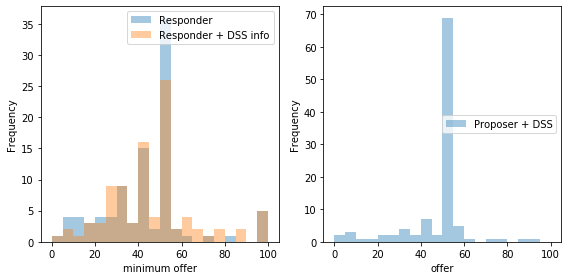

In [3]:

bins = list(range(0, 105, 5))
f, axes = plt.subplots(1, 2, figsize=(8,4))
ax = sns.distplot(df["min_offer"], hist=True, kde=False, axlabel="Responder minimum offer", bins=bins, label="Responder", ax=axes[0])
ax = sns.distplot(df["min_offer_final"], hist=True, kde=False, axlabel="minimum offer", bins=bins, label="Responder + DSS info", ax=axes[0])
_ = ax.set_ylabel("Frequency")
ax.legend(loc='best')

ax = sns.distplot(df_full["offer_final"], hist=True, kde=False, axlabel="offer", bins=bins, label="Proposer + DSS", ax=axes[1])
_ = ax.set_ylabel("Frequency")
ax.legend(loc='center right')
plt.tight_layout()

ax.figure.savefig(os.path.join(export_folder, "min_offer_offer.pdf"))

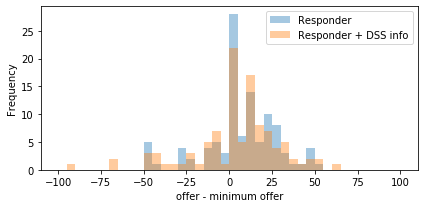

In [4]:
bins = list(range(-100, 105, 5))

plt.figure(figsize=(6,3))
offer_min_offer_diff = df_full["offer_final"] - df_full["min_offer"]
ax = sns.distplot(offer_min_offer_diff, hist=True, kde=False, axlabel="offer - minimum offer", bins=bins, label="Responder")
_ = ax.set_ylabel("Frequency")


offer_min_offer_diff = df_full["offer_final"] - df_full["min_offer_final"]
ax = sns.distplot(offer_min_offer_diff, hist=True, kde=False, axlabel="offer - minimum offer", bins=bins, label="Responder + DSS info", ax=ax)
plt.legend()
plt.tight_layout()
ax.figure.savefig(os.path.join(export_folder, "t12a-min_offer-diff.pdf"))

In [70]:
from core.models.metrics import cross_compute, avg_gain_ratio, gain_mean, rejection_ratio, loss_sum, MAX_GAIN

@np.vectorize
def _resp_gain(min_offer, offer):
    return 0 if offer < min_offer else offer
def resp_gain_mean(*args):
    return _resp_gain(*args).mean()

def prop_gain_mean(*args):
    return gain_mean(*args)

def get_infos(min_offer, offer, metrics=None, do_cross_compute=False):
    if metrics is None:
        metrics = [avg_gain_ratio, resp_gain_mean, prop_gain_mean, rejection_ratio, loss_sum]
    #df = pd.DataFrame()
    infos = dict()
    for idx, metric in enumerate(metrics):
        if do_cross_compute:
            infos[metric.__name__] = cross_compute(min_offer, offer, metric)
        else:
            infos[metric.__name__] = metric(min_offer, offer)

    return infos

**Proposer's performance**

In [89]:
df_infos = pd.DataFrame()
#Human (fixed-matching) performance t00
df_infos = df_infos.append(get_infos(df_full['min_offer'], df_full['offer_final']), ignore_index=True)
#Human (cross-matched) average performance t00
# df_infos = df_infos.append(get_infos(df_full['min_offer'], df_full['offer'], do_cross_compute=True), ignore_index=True)
# #Human + DSS (fixed-matching) performance t00
# df_infos = df_infos.append(get_infos(df_full['min_offer'], df_full['offer_final']), ignore_index=True)
# #Human + DSS(cross-matched) average performance t00
df_infos = df_infos.append(get_infos(df_full['min_offer_final'], df_full['offer_final']), ignore_index=True)
#Top-model (fixed 50% prediction) average performance t00
fixed_offer = MAX_GAIN // 2
# df_infos = df_infos.append(get_infos(df_full['min_offer'], [fixed_offer], do_cross_compute=True), ignore_index=True)

# df_infos.index = ["Responder", "Proposer (cross matched)", "Responder + DSS info", "Proposer + DSS (cross matched)", "AI-System"]
# df_infos.index = ["Responder", "Responder + DSS info"]

# df_infos = df_infos.loc[["Responder", "Responder + DSS info"]]
df_infos = df_infos.append(100*(df_infos.iloc[0] - df_infos.iloc[1]) / df_infos.iloc[0], ignore_index=True)
df_infos.index = ["Responder", "Responder + DSS info", "#Diff(%)"]
df_infos


,avg_gain_ratio,loss_sum,prop_gain_mean,rejection_ratio,resp_gain_mean
Responder,0.635742,2045.000000,39.142857,0.228571,38.000000
Responder + DSS info,0.583641,2100.000000,36.190476,0.276190,36.190476
#Diff(%),8.195339,-2.689487,7.542579,-20.833333,4.761905


In [91]:
def woa(offer_final, offer, ai_offer):
    res = (abs(offer_final - offer) ) / (abs(ai_offer - offer ))
    res = res[np.invert(np.isnan(res) | np.isinf(res))]
    res = np.clip(res, 0, 1)
    return abs(res).mean()

def get_resp_variation(df_full):
    df_full = df_full.copy()[df_full["min_offer"]>0]
    return 100 * ((df_full["min_offer_dss"] - df_full["min_offer"]) / df_full["min_offer"]).mean()

def get_rel_gain(df_full):
#     acc = df_infos['resp_gain_mean']['Responder']
#     acc_dss = df_infos['resp_gain_mean']['Responder + DSS info']
#     return 100 * abs(acc - acc_dss) / acc
    acc = _resp_gain(df_full['min_offer'], df_full['offer_final'])
    acc_dss = _resp_gain(df_full['min_offer_dss'], df_full['offer_final'])
    return mrc(acc_dss, acc)


def get_rel_rejection_rate(df_full):
    pass

def mrc(new, old):
    res = abs(new - old) / old
    res = res[np.invert(np.isnan(res) | np.isinf(res))]
    return 100 * abs(res).mean()
    
def get_dss_usage(df_full):
    return 100 * (df_full.ai_nb_calls > 0).mean()

print("rel_gain: ", round(get_rel_gain(df_full), 2), "%")
print("rel_min_offer_variation: ", round(get_resp_variation(df_full), 2), "%")
print("mard: ", round(mrc(df_full['min_offer_final'], df_full['min_offer']),2), "%")


rel_gain:  12.35 %
rel_min_offer_variation:  35.57 %
mard:  49.85 %


/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


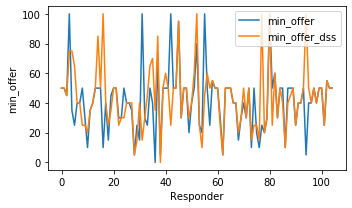

In [56]:

plt.figure(figsize=(5,3))
df_full["Responder"] = df_full.index
sns.lineplot(x='Responder', y='min_offer', data=df_full, label="min_offer")
ax = sns.lineplot(x='Responder', y='min_offer_final', data=df_full, label="min_offer_dss")
ax.set_ylabel("min_offer")

plt.legend()
plt.tight_layout()

ax.figure.savefig(os.path.join(export_folder, "t12a-min_offer.pdf"))

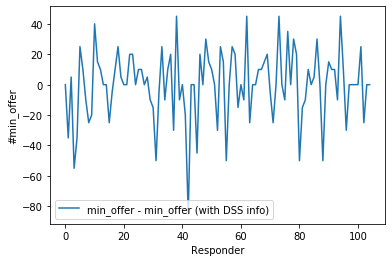

In [57]:
df_full["diff_min_offer"] = df_full["offer"] - df_full["min_offer"]
df_full["Responder"] = df_full.index
ax = sns.lineplot(x='Responder', y='diff_min_offer', data=df_full, label="min_offer - min_offer (with DSS info)")
ax.set_ylabel("#min_offer")

plt.legend()

In [92]:
df_infos = pd.DataFrame()
#Human (fixed-matching) performance t00
df_infos = df_infos.append(get_infos(df_full['min_offer'], df_full['offer']), ignore_index=True)
#Human (cross-matched) average performance t00
# df_infos = df_infos.append(get_infos(df_full['min_offer'], df_full['offer'], do_cross_compute=True), ignore_index=True)
# #Human + DSS (fixed-matching) performance t00
# df_infos = df_infos.append(get_infos(df_full['min_offer'], df_full['offer_final']), ignore_index=True)
# #Human + DSS(cross-matched) average performance t00
df_infos = df_infos.append(get_infos(df_full['min_offer_final'], df_full['offer_final']), ignore_index=True)
#Top-model (fixed 50% prediction) average performance t00
fixed_offer = MAX_GAIN // 2
# df_infos = df_infos.append(get_infos(df_full['min_offer'], [fixed_offer], do_cross_compute=True), ignore_index=True)

# df_infos.index = ["Responder", "Proposer (cross matched)", "Responder + DSS info", "Proposer + DSS (cross matched)", "AI-System"]
df_infos.index = ["Resp./Prop.", "Resp./Prop. + DSS/DSS info"]

# df_infos = df_infos.loc[["Resp./Prop.", "Resp./Prop. + DSS/DSS info"]]
df_infos = df_infos.append(100*(df_infos.iloc[0] - df_infos.iloc[1]) / df_infos.iloc[0], ignore_index=True)
df_infos.index = ["Resp./Prop.", "Resp./Prop. + DSS/DSS info", "#Diff (%)"]
df_infos


,avg_gain_ratio,loss_sum,prop_gain_mean,rejection_ratio,resp_gain_mean
Resp./Prop.,0.575657,2405.000000,35.714286,0.314286,32.857143
Resp./Prop. + DSS/DSS info,0.583641,2100.000000,36.190476,0.276190,36.190476
#Diff (%),-1.387033,12.681913,-1.333333,12.121212,-10.144928
